# Fruit image classification

Modified from: https://shirinsplayground.netlify.app/2020/09/keras_fruits_update/

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# path to image folders
path = "/Users/u0784726/Dropbox/Data/ml/fruits/"
train_image_files_path = path + "Training"

In [2]:
im_file = os.path.join(train_image_files_path, "Banana", "0_100.jpg")

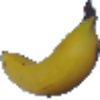

In [3]:
from PIL import Image               # to load images
from IPython.display import display # to display inline images
im = Image.open(im_file)
#show image
display(im)

### Project setup

Which fruits? This is the list of subdirectories in the training folder (and will also be used as labels for the images)

In [4]:
# fruits categories
fruit_list = ["Kiwi", "Banana", "Apricot", "Avocado", "Cocos", "Clementine", "Mandarine", "Orange",
                "Limes", "Lemon", "Peach", "Plum", "Raspberry", "Strawberry", "Pineapple", "Pomegranate"]
# number of output classes (i.e. fruits)
output_n = len(fruit_list)

Image down scaling

In [5]:
# image size to scale down to (original images are 100 x 100 px)
img_width = 20
img_height = 20
target_size = (img_width, img_height)

Number of available channels

In [6]:
# image RGB channels number
channels = 3

### Model setup

This is where we do any preprocessing of individual images. This would include augmentation - the creation of transformed versions of the original images. We create two image *generators*.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# training images
train_data_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.3
)

Define flows for the generators. These import images in batches, rather than trying to import all images at once. These generators can then be used while training the network. 

In [8]:
batch_size = 32

In [9]:
# training images
train_image_array_gen = train_data_gen.flow_from_directory(train_image_files_path,                                                            
                                                           target_size = target_size,
                                                           subset = 'training',
                                                           classes = fruit_list, 
                                                           class_mode = 'categorical',
                                                           seed = 42)

# validation images
valid_image_array_gen = train_data_gen.flow_from_directory(train_image_files_path, 
                                                           target_size = target_size,
                                                           subset = 'validation',
                                                           classes = fruit_list,
                                                           class_mode = 'categorical',
                                                           seed = 42)


Found 5401 images belonging to 16 classes.
Found 2308 images belonging to 16 classes.


In [10]:
## model definition
# number of training samples
train_samples = train_image_array_gen.n
# number of validation samples
valid_samples = valid_image_array_gen.n
# define batch size and number of epochs
batch_size = 32
epochs = 10

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D,
                          Dense,
                          LeakyReLU,
                          BatchNormalization, 
                          MaxPooling2D, 
                          Dropout,
                          Flatten)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [12]:
model = Sequential([   
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', 
           input_shape = (img_width, img_height, channels), activation = 'relu'),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same'),
    LeakyReLU(.5),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.25),
    Flatten(),
    Dense(units = 100, activation = 'relu'),
    Dropout(.5),
    Dense(units = output_n, activation = 'softmax')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        4624      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 20, 20, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

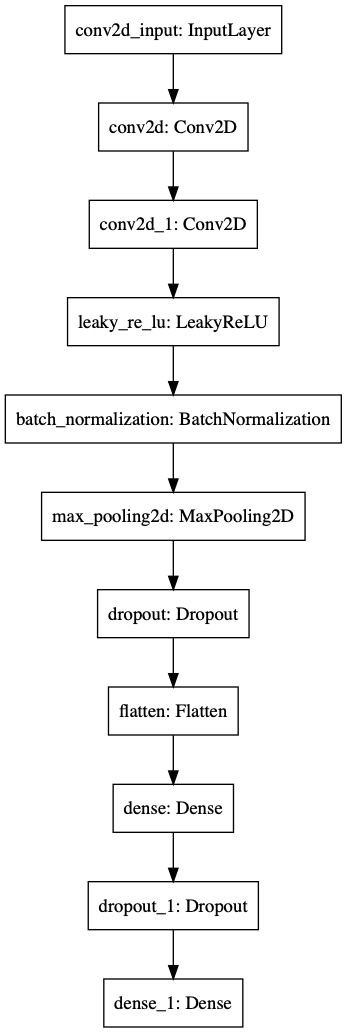

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [14]:
# compile the model
model.compile(loss = 'categorical_crossentropy', 
              metrics = ['accuracy'], 
              optimizer = RMSprop(lr = 1e-4, decay = 1e-6))

In [15]:
# train the model
hist = model.fit_generator(
  # training data
  train_image_array_gen,

  # epochs
  steps_per_epoch = train_samples // batch_size, 
  epochs = epochs, 

  # validation data
  validation_data = valid_image_array_gen,
  validation_steps = valid_samples // batch_size,

  # print progress
  verbose = 1
  #callbacks = [
    # save best model after every epoch
  #  ModelCheckpoint("fruits_checkpoints.h5", save_best_only = True),
    # only needed for visualising with TensorBoard
  #  TensorBoard(log_dir = "fruits_logs")
  #]
)

Epoch 1/10
168/168 [==============================] - 44s 263ms/step - loss: 2.0367 - accuracy: 0.3520 - val_loss: 2.1378 - val_accuracy: 0.5777
Epoch 2/10
168/168 [==============================] - 42s 252ms/step - loss: 1.0613 - accuracy: 0.6355 - val_loss: 1.0679 - val_accuracy: 0.9431
Epoch 3/10
168/168 [==============================] - 42s 253ms/step - loss: 0.6168 - accuracy: 0.7923 - val_loss: 0.3317 - val_accuracy: 0.9770
Epoch 4/10
168/168 [==============================] - 38s 228ms/step - loss: 0.3869 - accuracy: 0.8717 - val_loss: 0.1141 - val_accuracy: 0.9787
Epoch 5/10
168/168 [==============================] - 40s 239ms/step - loss: 0.2597 - accuracy: 0.9195 - val_loss: 0.0786 - val_accuracy: 0.9774
Epoch 6/10
168/168 [==============================] - 40s 240ms/step - loss: 0.1749 - accuracy: 0.9492 - val_loss: 0.0524 - val_accuracy: 0.9826
Epoch 7/10
168/168 [==============================] - 42s 250ms/step - loss: 0.1297 - accuracy: 0.9639 - val_loss: 0.0304 - val_ac

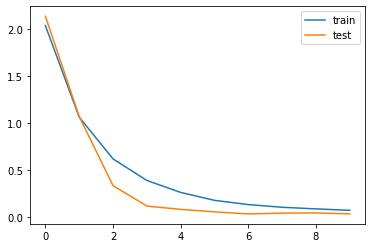

In [16]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
test_image_files_path = path + "Test"
# test images
test_data_gen = ImageDataGenerator(
    rescale = 1./255
)
test_image_array_gen = test_data_gen.flow_from_directory(test_image_files_path, 
                                                         target_size = target_size,
                                                         classes = fruit_list,
                                                         class_mode = 'categorical',
                                                         shuffle = False,
                                                         seed = 42)

Found 2592 images belonging to 16 classes.


In [19]:
test_loss, test_acc = model.evaluate(test_image_array_gen)

81/81 [==============================] - 3s 38ms/step - loss: 0.0365 - accuracy: 0.9938


In [20]:
print('Cross-entropy loss: %.4f'
      % test_loss)
print('Accuracy: %.4f'
      % test_acc)

Cross-entropy loss: 0.0365
Accuracy: 0.9938


In [21]:
test_pred = model.predict(test_image_array_gen)
test_pred.shape

(2592, 16)

In [22]:
test_obs = test_image_array_gen.classes

In [23]:
test_pred = np.argmax(test_pred, axis=1)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_obs, test_pred)

array([[156,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 166,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0, 164,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0, 143,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0, 158,   0,   0,   0,   0,   0,   0,   0,   8,
          0,   0,   0],
       [  0,   0,   0,   0,   0, 166,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 166,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 160,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 166,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 164,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   

In [25]:
cm = confusion_matrix(test_obs, test_pred)

df_cm = pd.DataFrame(cm, index = [i for i in fruit_list],
                  columns = [i for i in fruit_list])
df_cm

,Kiwi,Banana,Apricot,Avocado,Cocos,Clementine,Mandarine,Orange,Limes,Lemon,Peach,Plum,Raspberry,Strawberry,Pineapple,Pomegranate
Kiwi,156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Banana,0,166,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Apricot,0,0,164,0,0,0,0,0,0,0,0,0,0,0,0,0
Avocado,0,0,0,143,0,0,0,0,0,0,0,0,0,0,0,0
Cocos,0,0,0,0,158,0,0,0,0,0,0,0,8,0,0,0
Clementine,0,0,0,0,0,166,0,0,0,0,0,0,0,0,0,0
Mandarine,0,0,0,0,0,0,166,0,0,0,0,0,0,0,0,0
Orange,0,0,0,0,0,0,0,160,0,0,0,0,0,0,0,0
Limes,0,0,0,0,0,0,0,0,166,0,0,0,0,0,0,0
Lemon,0,0,0,0,0,0,0,0,0,164,0,0,0,0,0,0


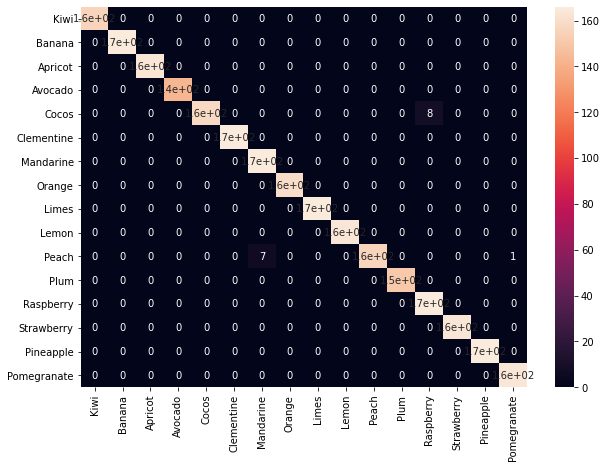

In [26]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

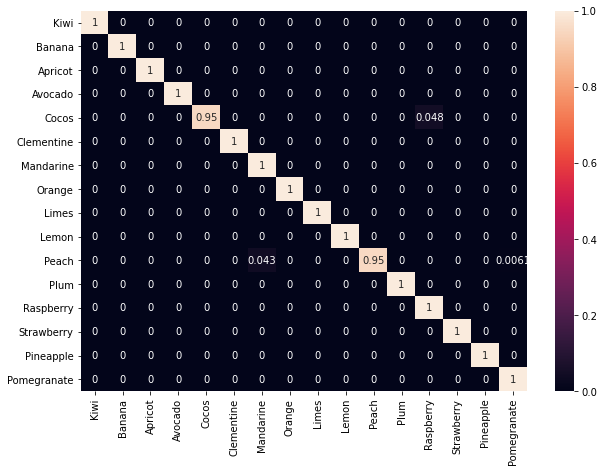

In [27]:
cm = confusion_matrix(test_obs, test_pred, normalize='true')

df_cm = pd.DataFrame(cm, index = [i for i in fruit_list],
                  columns = [i for i in fruit_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)